In [1]:
# Packages
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

### ***Use LSTM to predict the minute based data***

**NOTE** This notebook works on minute-base ppm data which is **different** with the origianl paper *"Coagulant dosage determination using deep learning-based graph attention multivariate time series forecasting model"* dataset. The data is collected by minutes.

In [5]:
# Parameters dataset
batch_size = 32
windows_size = 256

# train_valid_split = int(3086701 * 0.8)
# valid_test_split = int(3086701 * 0.9)

train_valid_split = int(3086701 * 0.5)
valid_test_split = int(3086701 * 0.7)

# Parameters module
input_dim = 9
hidden_dim = 32
output_dim = 1

# Parameters train
lr = 1e-3
epoches = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### ***1. Load data***

Load minute-based data from `data/ppm_processed/ppm.npy` and `data/ppm_processed/datetime.npy`. The `ppm.npy` is a matrix with the size `[time_length, num_feature] = [3086701, 11]` contains all the data points of all `11` features.

In this experiment setup, we use `'Raw_Flow', 'Raw_Temp', 'Raw_EC', 'Raw_TB', 'Raw_Alk', 'Raw_pH', 'Raw_TOC', 'Chl_Pre', 'Sed_Chl', 'Chl_Mid'` (all features except the `'Sed_TB', 'PACS_PPM`) features to predict the `'PACS_PPM` feature. 

We can have another experiment setup by using `'Raw_Flow', 'Raw_Temp', 'Raw_EC', 'Raw_TB', 'Raw_Alk', 'Raw_pH', 'Raw_TOC', 'Chl_Pre', 'Sed_Chl', 'Sed_TB', 'Chl_Mid', 'PACS_PPM` (all features except the `'Sed_TB'`) features to predic the `'Sed_TB'` feature.

In [3]:
# Load data
data = np.load('../data/ppm_processed/ppm.npy', allow_pickle=True)
print(f'Data shape: {data.shape}')

# Split input and target
data_inp = np.delete(data, [6, 9], axis=1) # Remove 'PACS_PPM' and 'Sed_TB'
data_tar = data[:, 6:7] # 'PACS_PPM' feature

# Normalize the data
data_inp = (data_inp - np.min(data_inp, axis=0)) / (np.max(data_inp, axis=0) - np.min(data_inp, axis=0))
data_tar = (data_tar - np.min(data_tar, axis=0)) / (np.max(data_tar, axis=0) - np.min(data_tar, axis=0))

feature_name = ['Raw_Flow', 'Raw_Temp', 'Raw_EC', 'Raw_TB', 'Raw_Alk', 'Raw_pH', 'Raw_TOC', 'Chl_Pre', 'Sed_Chl', 'Chl_Mid']
target_name = 'PACS_PPM'

# Load datetime
date_time = np.load('../data/ppm_processed/datetime.npy', allow_pickle=True)
print(f'Date time len: {len(date_time)}')

assert data.shape[0] == len(date_time)

Data shape: (3086701, 11)
Date time len: 3086701


#### ***2. Dataset and dataloader***

Dataloader batch output size:
- `inp`: `[batch_size, windows_size, num_feature]`
- `tar`: `[batch_size, windows_size, 1]`

In the first experiement setup, the dataloader batch output size would be :
- `inp`: `[batch_size, windows_size, 9]`
- `tar`: `[batch_size, windows_size, 1]`

Note here we overlap the windows by `1` timestep, e.g., the first windows is from `0` to `windows_size`, the second windows is from `1` to `windows_size+1`, etc.

In [4]:
# Dataset
class WDataset(Dataset):
    def __init__(self, data_inp, data_tar, windows_size):
        self.data_inp = data_inp
        self.data_tar = data_tar
        self.windows_size = windows_size

    def __len__(self):
        return self.data_inp.shape[0] - self.windows_size

    def __getitem__(self, idx):
        '''
        Return:
            - inp <torch.Tensor> [windows_size, feature_size]
            - tar <torch.Tensor> [windows_size]
        '''
        inp = self.data_inp[idx:idx+self.windows_size]
        tar = self.data_tar[idx:idx+self.windows_size]
        return inp, tar

train_set = WDataset(data_inp[:train_valid_split], data_tar[:train_valid_split], windows_size=windows_size)
valid_set = WDataset(data_inp[train_valid_split:valid_test_split], data_tar[train_valid_split:valid_test_split], windows_size=windows_size)
test_set  = WDataset(data_inp[valid_test_split:], data_tar[valid_test_split:], windows_size=windows_size)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Create a no shuffle dataloader for visualization
train_loader_no_shuffle = DataLoader(train_set, batch_size=batch_size, shuffle=False)

# Test the dataloder
inp, tar = next(iter(train_loader))
print(f'Train dataloader length: {len(train_loader)}')
print(f'Valid dataloader length: {len(valid_loader)}')
print(f'Input shape: {inp.shape}')
print(f'Target shape: {tar.shape}')

Train dataloader length: 48222
Valid dataloader length: 19284
Input shape: torch.Size([32, 256, 9])
Target shape: torch.Size([32, 256, 1])


#### ***3. Init Module***

Here we are going to test four modules:

1. `LSTM` module
2. `1D CNN + LSTM` module
3. `Attention + LSTM` module
3. `1D CNN + Attention + LSTM` module

In [15]:
# Init module - LSTM
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, dropout_prob):
        ''' Pure LSTM model for multi-variate time series regression '''
        super(LSTMAttention, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layer, 
            batch_first=True, 
            dropout=dropout_prob
        )
        self.query_linear = nn.Linear(hidden_dim, hidden_dim)
        self.key_linear = nn.Linear(input_dim, hidden_dim)
        self.value_linear = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim = hidden_dim,
            num_heads = 1,
            dropout = dropout_prob,
            batch_first = True
        )
        self.decoder = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # NOTE: h0, c0 is not necessary as input if we want to init them to zero
        out, _ = self.lstm(x)

        # Attention part
        query = self.query_linear(out)
        key = self.key_linear(x)
        value = self.value_linear(x)
        out = self.attention(query, key, value)[0]

        # FC part
        out = self.decoder(out)
        return out


model = LSTMAttention(input_dim, hidden_dim, num_layer=1, dropout_prob=0.2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
# Train model
epoch_train_loss = []
epoch_valid_loss = []
for epoch in tqdm(range(epoches)):
    iter_loss = []

    # SECTION - Train
    model.train()
    for idx, (inp, tar) in enumerate(train_loader):
        inp = inp.to(device, dtype=torch.float32)
        tar = tar.to(device, dtype=torch.float32)
        out = model(inp)

        optimizer.zero_grad()
        loss = criterion(tar, out)
        loss.backward()
        optimizer.step()

        iter_loss.append(loss.to('cpu').item())
    epoch_train_loss.append(sum(iter_loss)/len(iter_loss))

    # SECTION: Valid
    if epoch % 10 == 0:
        with torch.no_grad():
            iter_loss = []
            model.eval()
            for idx, (inp, tar) in enumerate(valid_loader):
                inp = inp.to(device, dtype=torch.float32)
                tar = tar.to(device, dtype=torch.float32)
                out = model(inp)

                loss = criterion(tar, out)
                iter_loss.append(loss.to('cpu').item())
            epoch_valid_loss.append(sum(iter_loss)/len(iter_loss))

100%|██████████| 10/10 [16:07<00:00, 96.78s/it]


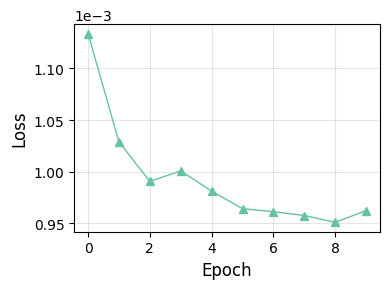

In [17]:
fig, ax = plt.subplots(1, figsize=(4, 3))

ax.plot(epoch_train_loss, label='Train Loss', color=cm.Set2(0), marker='^', lw=1)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(axis='both', color='black', alpha=0.1)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()

In [23]:
# Save the model
torch.save(model.state_dict(), '../checkpoint/lstm_attention_ep10.pt')

In [18]:
# Visualize the result on train and valid set
model.eval()

gt = []
pred = []

for idx, (inp, tar) in enumerate(train_loader_no_shuffle):
    inp = inp.to(device, dtype=torch.float32)
    tar = tar.to(device, dtype=torch.float32)
    out = model(inp)

    gt.append(tar[:, -1, 0].detach().cpu())
    pred.append(out[:, -1, 0].detach().cpu())

gt = torch.concatenate(gt, dim=0)
pred = torch.concatenate(pred, dim=0)

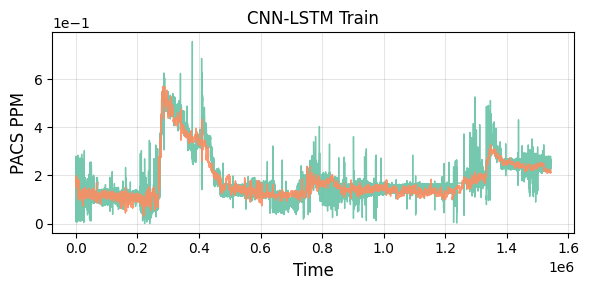

In [21]:
fig, ax = plt.subplots(1, figsize=(6, 3))

ax.plot(gt, label='Ground Truth', color=cm.Set2(0), lw=1, alpha=0.9)
ax.plot(pred, label='Prediction', color=cm.Set2(1), lw=1, alpha=0.9)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('PACS PPM', fontsize=12)
ax.set_title('CNN-LSTM Train', fontsize=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(axis='both', color='black', alpha=0.1)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('../fig/ppm/lstm_attention_train.png', dpi=300)

In [20]:
# Calculate multi measurement metrics
from math import sqrt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(gt, pred)
rmse = sqrt(mean_squared_error(gt, pred))
r2 = r2_score(gt, pred)
corr, _ = pearsonr(gt, pred)

print(f'MSE: {mse}, RMSE: {rmse}, R2: {r2}, Pearson correlation: {corr}')

MSE: 0.0009097824804484844, RMSE: 0.030162600691062507, R2: 0.9034887147309643, Pearson correlation: 0.9519778182109253
